If needed, **!pip install** (the needed package)

The dataset need to be locate at the same dictionary of this file. 

### PART 1: Data Exploration.

Basic dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17991 entries, 0 to 17990
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PscInspectionId      17991 non-null  int64  
 1   deficiency_code      17991 non-null  int64  
 2   annotation_id        17991 non-null  int64  
 3   username             17991 non-null  object 
 4   annotation_severity  17970 non-null  object 
 5   def_text             17991 non-null  object 
 6   InspectionDate       17991 non-null  object 
 7   VesselId             17991 non-null  int64  
 8   PscAuthorityId       17991 non-null  int64  
 9   PortId               17991 non-null  int64  
 10  VesselGroup          17991 non-null  object 
 11  age                  17991 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 1.6+ MB

Missing values:

PscInspectionId         0
deficiency_code         0
annotation_id           0
usern

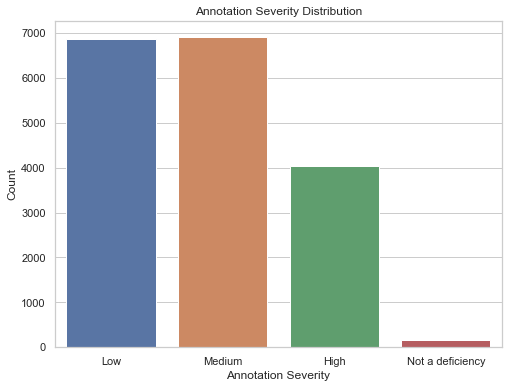

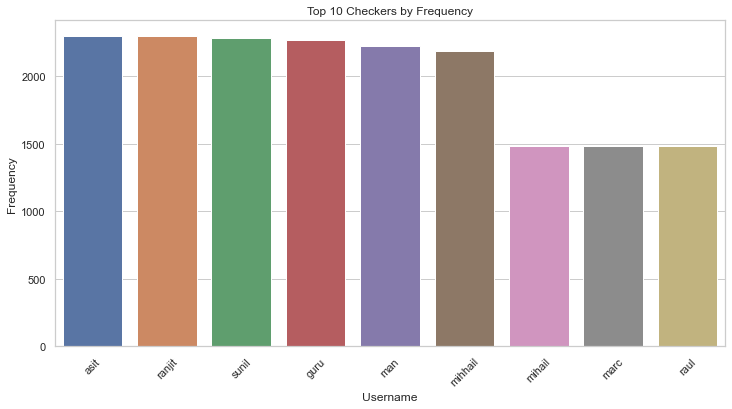

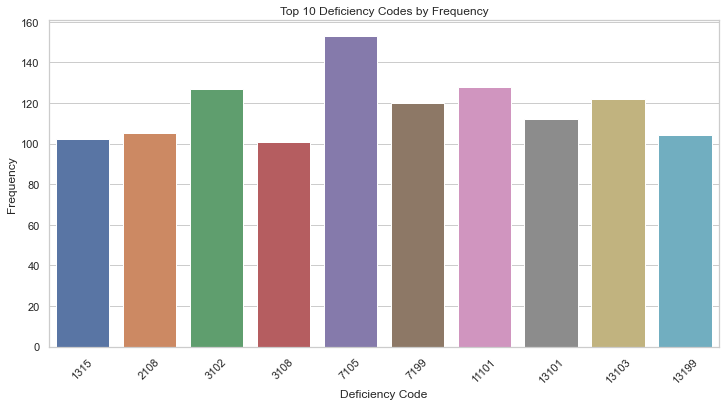

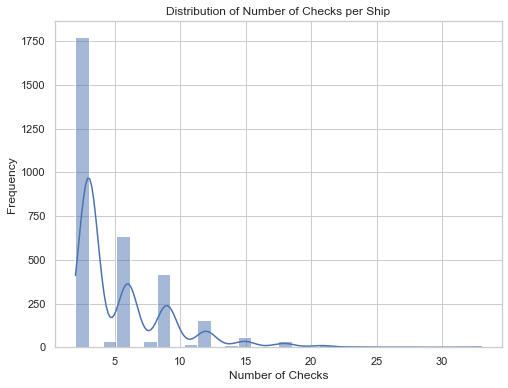

<Figure size 1008x576 with 0 Axes>

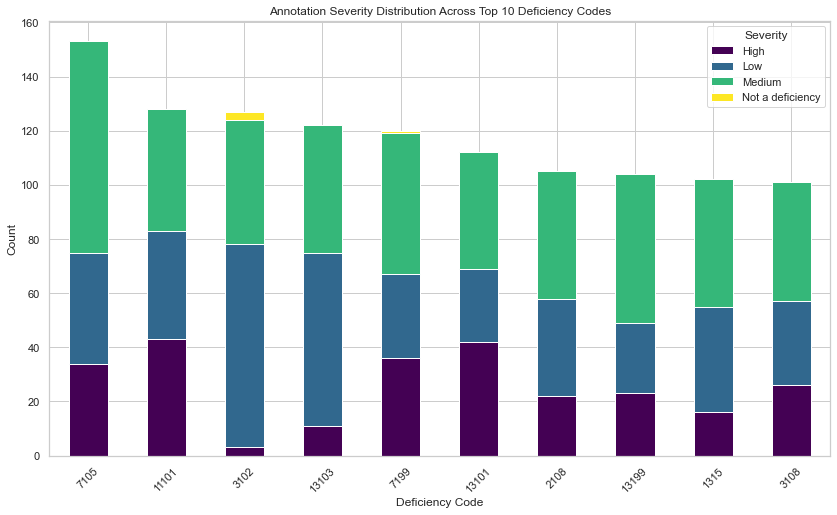

NameError: name 'user_ship_analysis' is not defined

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'psc_severity_train.csv'  # Path to the dataset file
data = pd.read_csv(file_path)

# Basic dataset information
print("Basic dataset information:\n")
data.info()

# Check for missing values
print("\nMissing values:\n")
print(data.isnull().sum())

# Visualize data distribution
print("Generating data distribution charts...")
sns.set(style="whitegrid")

# 1. Distribution of annotation_severity
plt.figure(figsize=(8, 6))
sns.countplot(x='annotation_severity', data=data, order=['Low', 'Medium', 'High', 'Not a deficiency'])
plt.title('Annotation Severity Distribution')
plt.xlabel('Annotation Severity')
plt.ylabel('Count')
plt.show()

# 2. Inspection frequency by username
plt.figure(figsize=(12, 6))
top_users = data['username'].value_counts().head(10)  # Top 10 users with the most inspections
sns.barplot(x=top_users.index, y=top_users.values)
plt.title('Top 10 Checkers by Frequency')
plt.xlabel('Username')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 3. Distribution of deficiency_code
plt.figure(figsize=(12, 6))
top_deficiency_codes = data['deficiency_code'].value_counts().head(10)  # Top 10 most common codes
sns.barplot(x=top_deficiency_codes.index, y=top_deficiency_codes.values)
plt.title('Top 10 Deficiency Codes by Frequency')
plt.xlabel('Deficiency Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 4. Distribution of the number of inspections per ship
plt.figure(figsize=(8, 6))
psc_inspection_counts = data['PscInspectionId'].value_counts()
sns.histplot(psc_inspection_counts, bins=30, kde=True)
plt.title('Distribution of Number of Checks per Ship')
plt.xlabel('Number of Checks')
plt.ylabel('Frequency')
plt.show()

# 5. Distribution of annotation_severity across deficiency_code
plt.figure(figsize=(14, 8))
top_deficiency_severity = data.groupby(['deficiency_code', 'annotation_severity']).size().unstack().fillna(0)
top_deficiency_severity = top_deficiency_severity.loc[top_deficiency_codes.index]
top_deficiency_severity.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Annotation Severity Distribution Across Top 10 Deficiency Codes')
plt.xlabel('Deficiency Code')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.show()

# Save exploration results
output_path = 'Maritime_Data_exploration.csv'  # Output file path
user_ship_analysis.to_csv(output_path)
print(f"Exploration results have been saved to {output_path}.")


### PART 2: Generate sub-category. 

### Preprocess the data, and generate a temp-dataset named "psc_comprehensive_analysis.csv", which include the result after dynamic K-means clustering. And then this file "psc_comprehensive_analysis.csv" will be the input file of part 3.

In [2]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from collections import defaultdict
import torch
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Download NLTK data (e.g., stopwords)
nltk.download('stopwords')

# Load the dataset
file_path = 'psc_severity_train.csv'  # Path to the dataset file
data = pd.read_csv(file_path)

# Extract text between "Deficiency/Finding:" and "Description Overview:" from the def_text field
def extract_def_text(text):
    if 'Deficiency/Finding:' in text and 'Description Overview:' in text:
        return text.split('Deficiency/Finding:')[1].split('Description Overview:')[0].strip()
    elif 'Deficiency/Finding:' in text:
        return text.split('Deficiency/Finding:')[1].strip()
    return text

# Enhanced text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Apply stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply text extraction and preprocessing
print("Extracting and preprocessing text...")
data['def_text_extracted'] = data['def_text'].apply(extract_def_text).apply(preprocess_text)

# BERT embedding generator (batch processing)
def generate_bert_embeddings(texts, model, tokenizer, batch_size=32):
    print("Generating BERT embeddings...")
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the embedding of the [CLS] token as the text representation, ensuring it is a 1D array
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Shape: (batch_size, 768)
        # Convert each embedding vector to shape (768,)
        for embedding in cls_embeddings:
            embeddings.append(embedding.reshape(-1))  # Ensure shape is (768,)
    return normalize(embeddings)

# Dynamically determine the number of clusters
def determine_clusters(embeddings, max_clusters=5):
    # If there are fewer than 2 samples, return 1 cluster
    if len(embeddings) <= 1:
        return 1
    
    # Check for duplicate data points
    unique_embeddings = np.unique(embeddings, axis=0)
    if len(unique_embeddings) == 1:
        print("Warning: All data points are identical, clustering cannot be performed.")
        return 1
    
    # If there are fewer than or equal to max_clusters samples, return the number of samples
    if len(embeddings) <= max_clusters:
        return len(embeddings)
    
    best_k = 1
    best_score = -1
    
    # Iterate through possible cluster numbers (from 2 to max_clusters)
    for k in range(2, min(max_clusters + 1, len(embeddings))):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        
        # Calculate silhouette score (only when the number of clusters is greater than 1)
        if k > 1:
            score = silhouette_score(embeddings, labels)
            # Update the best number of clusters
            if score > best_score:
                best_score = score
                best_k = k
    
    return best_k

# Initialize BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Group by deficiency_code and process each group
results = []
for deficiency_code, group in data.groupby('deficiency_code'):
    # Extract text from the current group
    texts = group['def_text_extracted'].tolist()

    # Generate BERT embeddings
    embeddings = generate_bert_embeddings(texts, model, tokenizer)

    # Dynamically determine the number of clusters
    n_clusters = determine_clusters(embeddings)

    # Perform KMeans clustering
    print(f"Clustering deficiency_code={deficiency_code}, number of clusters={n_clusters}...")
    if n_clusters == 1:
        # If the number of clusters is 1, assign the same label to all samples
        cluster_labels = np.zeros(len(embeddings), dtype=int)
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

    # Add clustering labels to the current group
    group['sub_category'] = cluster_labels

    # Retain the original deficiency_code and generate sub-category IDs
    group['sub_category_id'] = group['sub_category'].apply(lambda x: f"{deficiency_code}-{x}")

    # Save the results of the current group
    results.append(group[['deficiency_code', 'sub_category', 'sub_category_id', 'def_text', 'def_text_extracted', 'username', 'annotation_severity', 'PscInspectionId']])

# Combine the results of all groups into a single DataFrame
final_results = pd.concat(results, ignore_index=True)

# Save the results to a CSV file
output_path = 'psc_comprehensive_analysis.csv'  # Output file path
final_results.to_csv(output_path, index=False)

print(f"Processing complete. Results have been saved to {output_path}.")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanyuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Extracting and preprocessing text...
Generating BERT embeddings...
Clustering deficiency_code=1101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1104, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1105, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1106, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=1107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1117, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1119, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1122, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=1123, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1124, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1125, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly 

Clustering deficiency_code=1126, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1131, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1132, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1134, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=1136, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1137, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=1138, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1139, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1140, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1201, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1202, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1209, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1213, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1214, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1215, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1218, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1219, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1220, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1221, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1223, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1299, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1302, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1303, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1305, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1306, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1307, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1308, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1309, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1310, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1311, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1312, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1313, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=1314, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1315, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1316, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1318, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=1320, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1322, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1323, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1324, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1326, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1327, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=1328, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1329, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1330, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1331, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=1332, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=1333, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1336, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1337, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=1340, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2101, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2102, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=2103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2109, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2110, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=2111, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2112, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2117, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2118, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=2119, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2120, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2122, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2123, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2126, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=2128, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2132, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2133, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2134, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=2135, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=2136, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=2138, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=2199, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=3101, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=3102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3111, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=3112, number of 

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=4104, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=4105, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=4106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4107, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=4108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4114, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=4115, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=4116, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4117, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4118, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=4121, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5102, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=5103, number of clusters=3...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=5104, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=5105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5106, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=5107, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=5109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5111, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5114, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5115, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5116, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5118, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=5199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=6101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=6102, number of 

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=6108, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=6109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=6199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=7111, number of 

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=8102, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=8103, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=8104, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=8105, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=8106, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=8107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=8108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=8109, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=8110, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=8199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9109, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9110, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9111, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=9112, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9113, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9124, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9127, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9128, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=9130, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9131, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9132, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9198, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9201, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9203, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9204, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9205, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9206, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9207, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9208, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=9209, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9210, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9211, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9213, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9216, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9218, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9219, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9220, number of clusters=3...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly 

Clustering deficiency_code=9221, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9222, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9223, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9225, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9226, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=9227, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9228, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9229, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9232, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9233, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=9236, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=9297, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9298, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=9299, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10106, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=10107, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=10109, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10111, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10112, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10114, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10116, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10117, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10118, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10119, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10120

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=10124, number of clusters=3...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=10125, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=10126, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10127, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10128, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10129, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=10132, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=10133, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10135, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10136, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10137, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10138, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=10199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11101, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=11102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11105

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=11106, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=11107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11112, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11116, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11117, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=11118, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11119, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11122, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11123

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=11127, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=11128, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11129, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11131, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11132, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11134, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11135, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=11199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=12101, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=12104, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=12106, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=12107, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=12108, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=12199, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=13101, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=13102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=13103, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=13104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=13105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=13106, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=13107, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=13108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=13199, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14108, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=14110, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14119, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14121, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14122, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14199, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14302, number of clusters=3...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14304, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14402, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14403, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14404, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14499, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14501, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14502, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14503, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14599, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14601, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14602, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14603, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14604, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14606, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14608, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14610, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14611, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14612, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14613, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14614, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14615, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14616, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14617, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14699, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14703, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14799, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14801, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14802, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14804, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14806, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14807, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=14808, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=14810, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14811, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=14899, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=15100, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=15101, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=15102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15104, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15106, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15107, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15108, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15109, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=15110, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=15111, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=15113, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15150, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=15199, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=16100, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=16101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=16103, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=16104, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=16105, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=16106, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=16107, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=16199, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=17101, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly 

Clustering deficiency_code=17199, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18101, number of clusters=2...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18103, number of clusters=4...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18199, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=18201, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18202, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18203, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18204, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18299, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18301, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=18302, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18303, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18304, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18305, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18306, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18308, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18311, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18312, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18313, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18314, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18315

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18406, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=18407, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18408, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18409, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18410, number of clusters=5...
Generating BERT embeddings...


/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18411, number of clusters=3...
Generating BERT embeddings...
Clustering deficiency_code=18412, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18413, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18414, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18415, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18416, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18417, number of clusters=4...
Generating BERT embeddings...
Clustering deficiency_code=18418, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18419, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18420, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18421, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18423

/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/Users/hanyuchen/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Clustering deficiency_code=18431, number of clusters=2...
Generating BERT embeddings...
Clustering deficiency_code=18432, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=18499, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=99101, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=99102, number of clusters=5...
Generating BERT embeddings...
Clustering deficiency_code=99103, number of clusters=5...
Processing complete. Results have been saved to psc_comprehensive_analysis.csv.


### PART 3: Scoring system.

### Give the final annotation of one specific ship

In [3]:
import pandas as pd

# Load data
file_path = "psc_comprehensive_analysis.csv"
data = pd.read_csv(file_path)

# Step 1: Calculate the frequency distribution of Low, High, Mid, and Not a deficiency for each engineer
# Group by username and annotation_severity to count occurrences
engineer_distribution = (
    data.groupby(['username', 'annotation_severity'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Normalize to get probabilities for Low, High, Mid, and Not a deficiency
engineer_probability = engineer_distribution.div(engineer_distribution.sum(axis=1), axis=0)

# Step 3: Calculate gradient for each problem and determine final severity
# Group data by sub_category_id
problem_groups = data.groupby(['sub_category_id'])

# Initialize a result dictionary to store final severities and their scores
final_severities = []

for problem, group in problem_groups:
    # Count occurrences of each engineer's judgment for this problem (gradient based on engineer judgments)
    engineer_counts = group['username'].value_counts()

    # Calculate scores for Low, Mid, High, and Not a deficiency based on engineer probabilities
    scores = {'Low': 0, 'Medium': 0, 'High': 0, 'Not a deficiency': 0}
    for _, row in group.iterrows():
        engineer = row['username']
        severity = row['annotation_severity']

        # Multiply the count of the engineer's judgments by their probability for this severity
        if severity in scores:
            scores[severity] += engineer_counts[engineer] * engineer_probability.loc[engineer, severity]

    # Determine the final severity with the highest score
    final_severity = max(scores, key=scores.get)

    # Append the problem details and scores to the result
    final_severities.append({
        'Problem': problem,
        'Final Severity': final_severity,
        'High Score': scores['High'],
        'Medium Score': scores['Medium'],
        'Low Score': scores['Low'],
        'Not a deficiency Score': scores['Not a deficiency'],
        'def_text': group['def_text'].iloc[0],
        'Def Text Extracted': group['def_text_extracted'].iloc[0]  # Assuming the text is the same within a group
    })

# Convert final severities to a DataFrame for easy analysis
final_severities_df = pd.DataFrame(final_severities)

# Save the result to a file
final_severities_df.to_csv("final_severities_with_scores.csv", index=False)

# Display the result
print("Final Severities for Each Problem with Scores:")
print(final_severities_df)

Final Severities for Each Problem with Scores:
      Problem Final Severity  High Score  Medium Score  Low Score  \
0     10101-0         Medium    0.000000      0.748009   0.306673   
1     10101-1           High    6.638966      1.716996   1.528008   
2     10101-2           High   11.887947      7.238147   0.000000   
3     10101-3         Medium    1.018627      5.341298   0.411657   
4     10101-4         Medium    0.238524      0.913683   0.000000   
...       ...            ...         ...           ...        ...   
1947  99103-0            Low    0.000000      0.910063   1.861224   
1948  99103-1           High    0.767805      0.000000   0.000000   
1949  99103-2         Medium    1.235731      1.837101   0.591819   
1950  99103-3            Low    0.000000      0.224122   1.809222   
1951  99103-4         Medium    0.000000      1.565076   0.591819   

      Not a deficiency Score  \
0                        0.0   
1                        0.0   
2                        0.0